# Application of statistical inference techniques to Chicago Rideshare dataset



Since November 2018, rideshare providers (Lyft, Uber, etc) operating in Chicago are required by ordinance to submit periodic data reports with basic rideshare information to the City.  The main [Trips dataset](https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips/m6dm-c72p) includes information about individual rides, including starting and ending times and locations, fares and tips, and whether the rides were pooled.  The Trips data are anonymized, so trip starting and ending locations are generalized to the nearest census tract, and drivers cannot be linked to particular rides they provided.  The currently available dataset goes through June 2019, however the portion used for this exercise goes from November 2018 through March 2019.

To prepare for the analyses and visualizations in this notebook, the Trips data was cleaned, aggregated, and enriched with climate and census data.  A preliminary exploration of this dataset is available [here](https://github.com/LisaATaylor/Rideshare/blob/master/Chicago%20Rideshare%20Data%20Story.ipynb).

In [55]:
%config IPCompleter.greedy=True

In [56]:
import csv
import os
import matplotlib.pyplot as plt
from datetime import datetime,date,timedelta
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import contextily as ctx #for basemaps
import scipy.stats as stats


In [57]:
plt.rcParams['figure.figsize'] = [15, 5]
sns.set()

In [84]:
#load pickled/munged data 
datadir=r'/Users/rtaylor/Desktop/Springboard/DataSets/Rideshare'

#5% sample of rides from raw data
ridesdf=pd.read_pickle(os.path.join(datadir,'sampled_reformatted_df'))

#data aggregated hourly by pickup census tract, with census info, weather and geography
daily_df=pd.read_pickle(os.path.join(datadir,'agg_daily_all_gdf'))
daily_gdf = gpd.GeoDataFrame(daily_df, geometry='geometry')

#data aggregated daily by pickup census tract, with geography
agg_hourly_all=pd.read_pickle(os.path.join(datadir,'agg_hourly_all_gdf'))
hourly_gdf= gpd.GeoDataFrame(agg_hourly_all, geometry='geometry')


## Q1.  Is pickup frequency poisson distributed?

In [99]:
# Look at distribution of pickups.  Is it a poisson distribution?
# Zoom in on small area/time:  weekday lunch (11-2) downtown
downtown_df=agg_hourly_all.loc['17031839100']
downtown_df=downtown_df.loc[(downtown_df.Hour.isin([11,12,13]))&(downtown_df.DOW<5)]
ev_rides=downtown_df['NumRides'].mean()
ev_rides

26.174454828660437

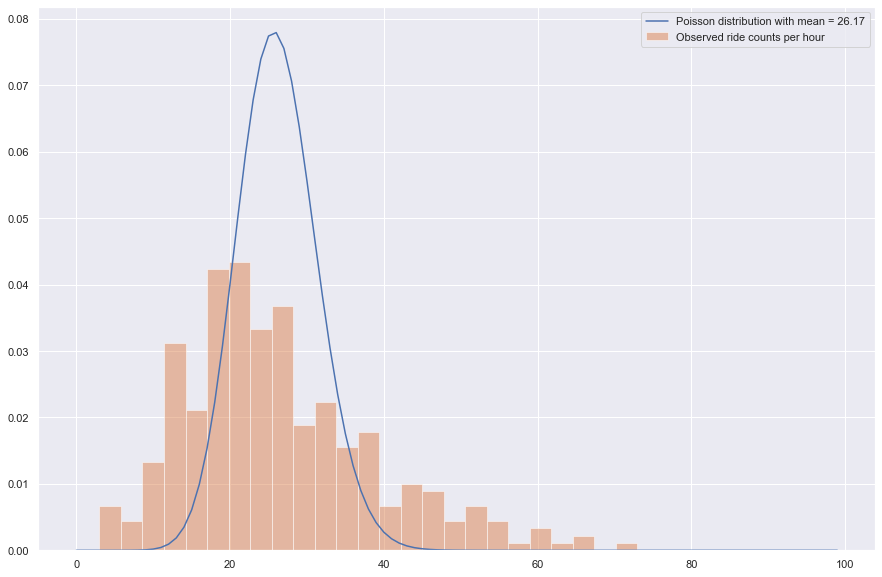

In [100]:
fig,ax=plt.subplots(figsize=[15,10])
rv=stats.poisson(ev_rides)
x=np.arange(0,100)
ax.plot(x,rv.pmf(x),label='Poisson distribution with mean = {:.2f}'.format(ev_rides))
downtown_df['NumRides'].hist(bins=25,density=True,ax=ax,label='Observed ride counts per hour',alpha=0.5)
ax.legend()

### Doesn't appear to fit poisson particularly well

## Q2a:  Are riders picked up from the airport more likely to tip?
### Approach:  
* 2-sample Z test comparing proportions of rides with tips
* samples are from airport census tracts and all other tracts

In [103]:
# Are riders picked up from airports more likely to tip than riders from other locations?
# Prepare data (recall, ridesdf is 5% sample of full rideshare dataset)
tracts={'OHare Airport':'17031980000','Midway Airport':'17031980100','Downtown':'17031839100','Wicker Park':'17031240300','Forest Glen':'17031120200','University of Chicago':'17031836200'}
ridesdf['Tipped']=ridesdf['Tip']>0
ridesdf['AirportPU']=ridesdf['PUCensusTract'].isin([tracts['OHare Airport'],tracts['Midway Airport']])

tipsdf = ridesdf.groupby('AirportPU')['Tipped'].agg([sum,'count'])
tipsdf.columns =['NumTippedRides','NumRides']
tipsdf['PropTips']=tipsdf['NumTippedRides']/tipsdf['NumRides']

# Two sample Z-test for difference between sample proportions
# CLT applies if np and n(1-p) are both >5
# Ho:  p_air = p_other
# Alpha = 0.05 --> Z = +/- 1.96
p_all = tipsdf['NumTippedRides'].sum()/tipsdf['NumRides'].sum()

n_other=tipsdf.loc[False,'NumRides']
n_air=tipsdf.loc[True,'NumRides']
p_other=tipsdf.loc[False,'PropTips']
p_air=tipsdf.loc[True,'PropTips']

sem =p_all*(1-p_all)*(1/n_other + 1/n_air) #n is big, this value becomes very small
Z = (p_air-p_other)/np.sqrt(sem) #SEM is small, so Z gets very large
print('Z-score: {:0.0f}'.format(Z))
#This is a high z-score
#Reject Ho, conclude the odds of getting a tip are higher for airport pickups

Z-score: 80


In [271]:
tipsdf


,NumTippedRides,NumRides,PropTips
Pooled,,,
False,252320.0,1272018,0.198362
True,24407.0,250714,0.097350


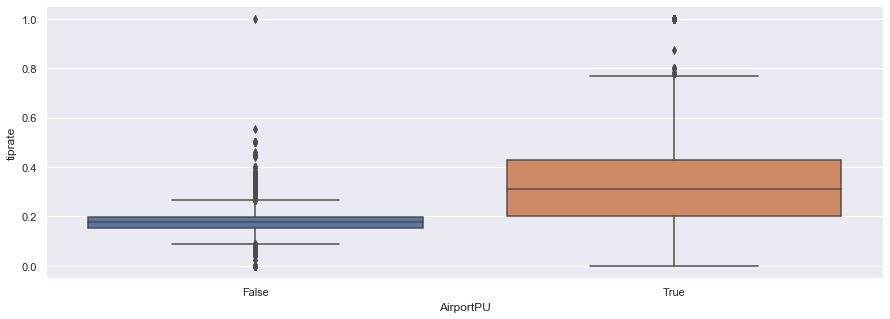

In [110]:
# groupby airport/not airport, hour
# tabulate average tipping proportions per hour
airport_grp=ridesdf.groupby(['AirportPU','TripStart'])['Tipped'].agg([sum,'count'])
airport_grp['tiprate']=airport_grp['sum']/airport_grp['count']
airport_grp=airport_grp.reset_index()
sns.boxplot(y='tiprate',x='AirportPU',data=airport_grp)


### Q2b:  Are pooled or unpooled rides more likely to tip?

In [274]:
# Are pooled riders more likely to tip than riders from other locations?
# Prepare data (recall, ridesdf is 5% sample of full rideshare dataset)
ridesdf['Pooled']=ridesdf['TripsPooled'].apply(lambda x: True if x>1 else False)

tipsdf = ridesdf.groupby('Pooled')['Tipped'].agg([sum,'count'])
tipsdf.columns =['NumTippedRides','NumRides']
tipsdf['PropTips']=tipsdf['NumTippedRides']/tipsdf['NumRides']

# Two sample Z-test for difference between sample proportions
# CLT applies if np and n(1-p) are both >5
# Ho:  p_air = p_other
# Alpha = 0.05 --> Z = +/- 1.96
p_all = tipsdf['NumTippedRides'].sum()/tipsdf['NumRides'].sum()

n_other=tipsdf.loc[False,'NumRides']
n_pool=tipsdf.loc[True,'NumRides']
p_other=tipsdf.loc[False,'PropTips']
p_pool=tipsdf.loc[True,'PropTips']

sem =p_all*(1-p_all)*(1/n_other + 1/n_pool)
Z = (p_pool-p_other)/np.sqrt(sem)
print('Z-score: {:0.0f}'.format(Z))
#This is a high z-score
#Reject Ho, conclude the odds of getting a tip are lower for pooled rides

Z-score: -120


(-1, 10.5)

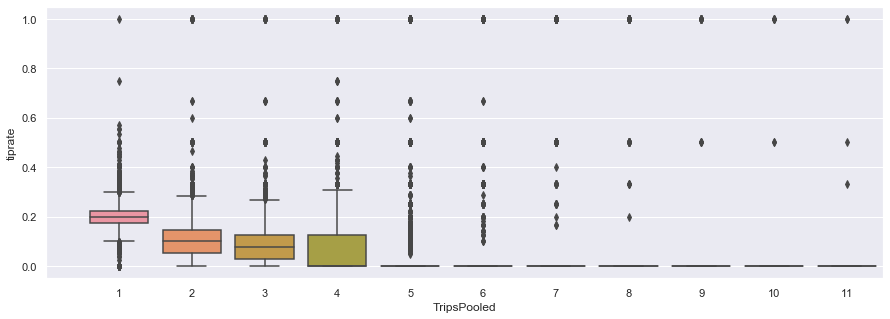

In [281]:
pool_grp=ridesdf.groupby(['TripsPooled','TripStart'])['Tipped'].agg([sum,'count'])
pool_grp['tiprate']=pool_grp['sum']/pool_grp['count']
pool_grp=pool_grp.reset_index()
ax=sns.boxplot(y='tiprate',x='TripsPooled',data=pool_grp)
ax.set_xlim(-1,10.5)
#tiprate is proportion of rides with a tip

## Q3:  Can pickup intervals in low utilization tracts be modeled with an Exponential distribution?


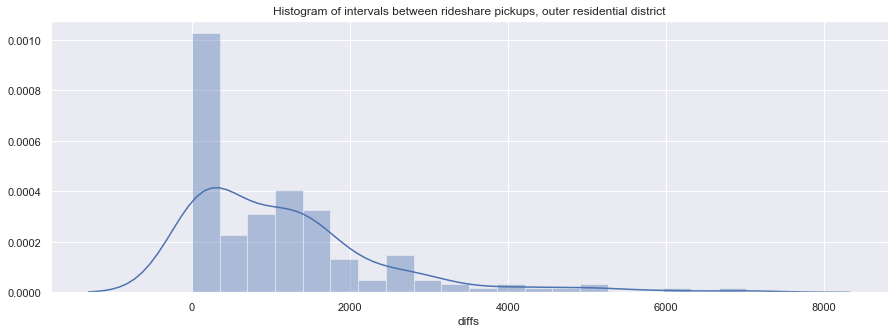

In [251]:
#Attempt to fit exponential distribution to pickups from outer residential district

samp_df=pd.read_pickle(os.path.join(datadir,'chicago_pickle_05')) 

putimes=samp_df.loc[samp_df.PUCensusTract==17031120200,'TripStart']#
putimes=putimes.sort_values().to_frame()
putimes['diffs'] = putimes.TripStart.diff()
putimes['diffs']=putimes['diffs'].astype('timedelta64[m]')
putimes=putimes.dropna()
#restrict to evening
putimes=putimes.loc[putimes.TripStart.dt.hour.isin(list(range(6,22)))]

ax=sns.distplot(putimes['diffs'],bins=20)
ax.set_title('Histogram of intervals between rideshare pickups, outer residential district')
mn=putimes.diffs.mean()

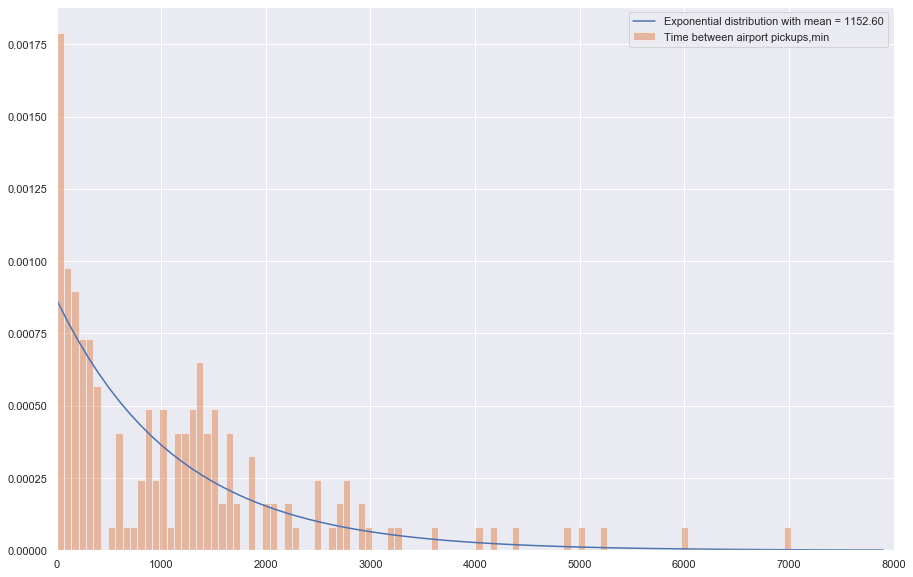

In [252]:
fig,ax=plt.subplots(figsize=[15,10])
#rv=stats.expon(0,putimes.shape[0])#putimes['diffs'].mean(),1000)
x=np.arange(0,8000,100)
ax.plot(x,stats.expon.pdf(x=x,scale=mn),label='Exponential distribution with mean = {:.2f}'.format(putimes['diffs'].mean()))
putimes['diffs'].hist(bins=100,density=True,ax=ax,label='Time between airport pickups,min',alpha=0.5)
ax.set_xlim(0,8000)
ax.legend();


Looks exponential, could verify with ecdf?

## Q4: What total fare should a driver expect for an O'Hare pickup?
### Approach:
* Look at distribution of total fares - is it normally distributed?
* Calculate 95% confidence interval of the mean for all pickups from O'Hare
* Use ECDF to estimate most probable range of fares

In [10]:
ohare = ridesdf.loc[ridesdf['PUCensusTract']==tracts['OHare Airport']]
fares = ohare['TripTotal'].values
logfares=np.log10(fares)

(array([4.4200e+02, 1.2960e+03, 8.0760e+03, 1.2116e+04, 5.6890e+03,
        2.2050e+03, 1.1610e+03, 6.3700e+02, 2.4900e+02, 2.4200e+02,
        1.5000e+02, 8.7000e+01, 6.1000e+01, 2.3000e+01, 1.0000e+01,
        7.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 10.  ,  17.24,  24.48,  31.72,  38.96,  46.2 ,  53.44,  60.68,
         67.92,  75.16,  82.4 ,  89.64,  96.88, 104.12, 111.36, 118.6 ,
        125.84, 133.08, 140.32, 147.56, 154.8 ]),
 <a list of 20 Patch objects>)

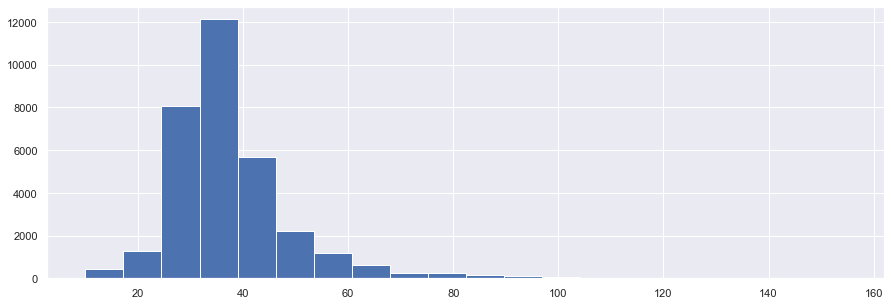

In [11]:
plt.hist(fares,bins=20)#,bins=np.arange(0,100,2.5))

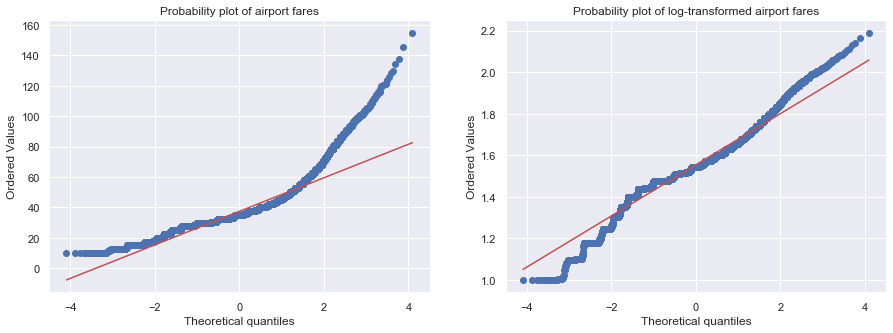

In [12]:
#looks almost normal, except extended right tail.  Look at QQ plots
fig,ax=plt.subplots(1,2)
stats.probplot(fares, dist='norm',plot=ax[0])
stats.probplot(logfares, dist='norm',plot=ax[1])
ax[0].set_title('Probability plot of airport fares')
ax[1].set_title('Probability plot of log-transformed airport fares');

In [13]:
# calcuate 95% confidence interval of mean total fare - CLT and bootstrap
nfares = len(fares)
stdfares = np.std(fares)
semfares = stdfares/np.sqrt(nfares)
avgfare = np.mean(fares)
zc = stats.norm.ppf(0.025)
moe = np.array([zc*semfares,(0-zc)*semfares])
ci = avgfare + moe

In [14]:
print(ci)
#large sample size results in a tight confidence interval

[37.30335865 37.56240349]


In [15]:
#bootstrap CI of mean
bmeans=np.empty(1000)
for n in range(1000):
    bss=np.random.choice(fares,replace=True,size=nfares)
    bmeans[n]=np.mean(bss)

np.percentile(bmeans,[2.5,97.5])

array([37.30827566, 37.56305034])

The probability of receiving a total fare < $20 for an airport pickup: 2.84%
The probability of receiving a total fare > $80 for an airport pickup: 1.31%
The probability of receiving a total fare between $30 and $60: 74.86%


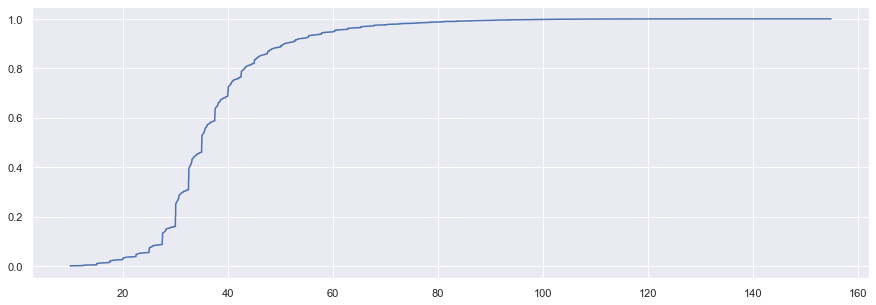

In [28]:
#generate cdf of fares distribution
def ecdf(arr):
    y=np.linspace(0,1,len(arr))
    x=np.sort(arr)
    return(x,y)

x,y=ecdf(fares)
plt.plot(x,y)

#probability of a fares in specified ranges:
print('The percentage of total fares < $20 for an airport pickup: {:0.2f}%'.format(np.interp(20, x, y)*100))
print('The percentage of total fares > $80 for an airport pickup: {:0.2f}%'.format((1-np.interp(80, x, y))*100))
print('The percentage of total fares between $30 and $60: {:0.2f}%'.format((np.interp(60, x, y)-np.interp(30, x, y))*100))

In [50]:
#bootstrap:  70% of fares will fall in what range? (get confidence intervals on 15th and 85th percentiles)
bci=np.empty([1000,2])

for n in range(1000):
    bss=np.random.choice(fares,replace=True,size=nfares)
    bci[n]=np.percentile(bss,[15,85])
np.mean(bci,axis=0)
#95% confidence interval on 5th percentile
print(np.percentile(bci[:,0],[2.5,97.5]))
print(np.percentile(bci[:,1],[2.5,97.5]))

[28.15 29.  ]
[45.8  46.65]


## Q5:  Does weather impact ride time, length?
Ho = ride distance  or duration is independent of weather

Ha = ride distances or durations vary by weather

Z-test for difference between two means, evaluation uses average travel time/distances for hourly-aggregated data

(0, 5000)

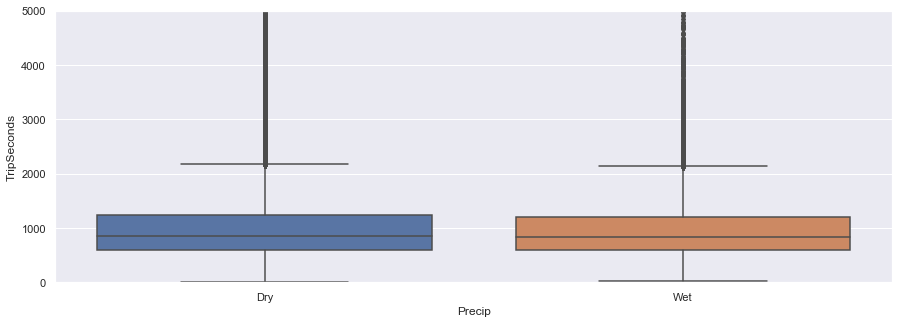

In [253]:
dry=agg_hourly_all.loc[agg_hourly_all['Precip']=='Dry','TripSeconds']
wet=agg_hourly_all.loc[agg_hourly_all['Precip']!='Dry','TripSeconds']
len(dry),len(wet)
ax=sns.boxplot(x='Precip',y='TripSeconds',data=agg_hourly_all)
ax.set_ylim(0,5000)

In [254]:
#stderr of diff between two means
wstd=np.std(wet)
dstd=np.std(dry)
sterr=np.sqrt(((wstd)**2)/len(wet) + ((dstd)**2)/len(dry))
wmean=np.mean(wet)
dmean=np.mean(dry)

z=(wmean-dmean)/sterr

prob_z=stats.norm.cdf(z)
print('Z: {} p: {}'.format(z,prob_z))
#fail to reject null hypothesis, can't prove there is a difference between trip times between wet and dry days

Z: -0.9205253298731965 p: 0.17864915128531678


Z: -5.77319194781863 p: 3.889187312079879e-09


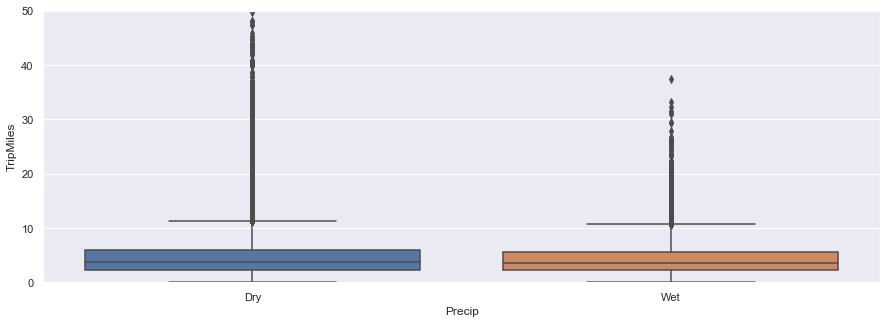

In [259]:
#Repeat for distance
dry=agg_hourly_all.loc[agg_hourly_all['Precip']=='Dry','TripMiles']
wet=agg_hourly_all.loc[agg_hourly_all['Precip']!='Dry','TripMiles']
len(dry),len(wet)
ax=sns.boxplot(x='Precip',y='TripMiles',data=agg_hourly_all)
ax.set_ylim(0,50)

#stderr of diff between two means
wstd=np.std(wet)
dstd=np.std(dry)
sterr=np.sqrt(((wstd)**2)/len(wet) + ((dstd)**2)/len(dry))
wmean=np.mean(wet)
dmean=np.mean(dry)

z=(wmean-dmean)/sterr

prob_z=stats.norm.cdf(z)
print('Z: {} p: {}'.format(z,prob_z))

In [261]:
wmean,dmean,wmean-dmean

(4.586203546553535, 4.741150075811135, -0.15494652925760022)

We conclude that weather doesn't influence average time per trip (counterintuitive - shouldn't trip times go up?)
We also conclude that average ride distances are shorter during wet periods (this makes trip time make more sense: trips are shorter but take same time in bad weather). The magnitude of the effect is small (~0.15 mile).

## More questions: same evaluation using median income?

In [262]:
agg_hourly_all['MedIncome']=agg_hourly_all['MedIncome'].astype(int)
income_fare_df=agg_hourly_all.loc[(agg_hourly_all['MedIncome']>0)]


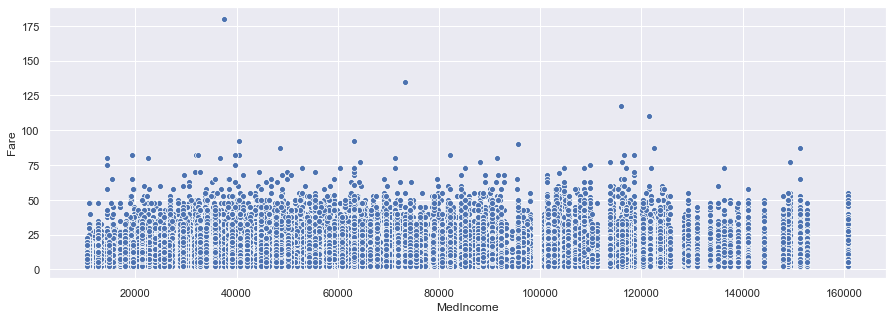

In [263]:
sns.scatterplot(x='MedIncome',y='Fare',data=income_fare_df)